In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch import optim as optim
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
from skimage import io
import os

# Set random seed for reproducibility
manualSeed = 42
torch.manual_seed(manualSeed)

In [2]:
# Batch size during training
batch_size = 140

# Image size 
image_size = 32

# Number of channels in the training images. For black and white images this is 1.
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of y label vector
ny = 2

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 100

# Image saving interval
interval = 10

# Learning rate for optimizers
lr = 0.0002

# Beta hyperparams for Adam optimizers
beta = (0.5, 0.999)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class FontDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.fonts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fonts_frame)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.fonts_frame.iloc[idx, 0])

        image = io.imread(img_path)
        font_attributes = self.fonts_frame.iloc[idx, 1:]
        font_attributes = np.array([font_attributes])
        font_attributes = font_attributes.astype("int").reshape(-1, 3)

        if self.transform:
            image = self.transform(image)

        return image, font_attributes


In [5]:
data_loader = torch.utils.data.DataLoader(FontDataset(csv_file="A_1/Fonts.csv", 
                            root_dir="A_1/PNG/", 
                            transform=transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Pad(30, 255),
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                 (0.5,), (0.5,))
                            ])),
  batch_size=batch_size, shuffle=True);

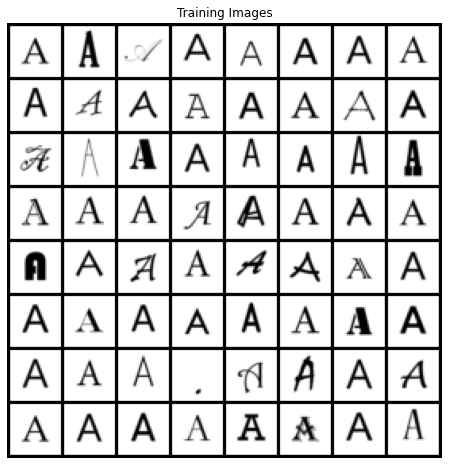

In [6]:
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class GeneratorModel(nn.Module):
    def __init__(self):
        super(GeneratorModel, self).__init__()
        input_dim = nz + ny
        output_dim = image_size**2
        self.label_embedding = nn.Embedding(ny, ny)
        
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x,c], 1)
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)
        return output.to(device)

In [9]:
class DiscriminatorModel(nn.Module):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()

        self.data = nn.Sequential(
            # input size: 1 x 32 x 32
            nn.Conv2d(nc, ndf*2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
            # output size: 64 x 16 x 16
        )

        self.labels = nn.Sequential(
            # input size: 2 x 32 x 32
            nn.Conv2d(ny, ndf*2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
            # state size: 64 x 16 x 16
        )
       
        self.main = nn.Sequential(
           # input size: 128 x 16 x 16
           nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
           nn.BatchNorm2d(ndf*8),
           nn.LeakyReLU(0.2, inplace=True),
           # state size: 256 x 8 x 8
           
           nn.Conv2d(ndf*8, ndf*16, 4, 2, 1, bias=False),
           nn.BatchNorm2d(ndf*16),
           nn.LeakyReLU(0.2, inplace=True),
           # state size: 512 x 4 x 4

           nn.Conv2d(ndf*16, 1, 4, 1, 0, bias=False),
           nn.Sigmoid() 
       )

    def forward(self, x, labels):
        x = self.data(x)
        c = self.labels(labels)
        input = torch.cat([x, c], 1)

        return self.main(input).to(device)

In [10]:
generator = GeneratorModel()

generator.to(device)

GeneratorModel(
  (label_embedding): Embedding(2, 2)
  (hidden_layer1): Sequential(
    (0): Linear(in_features=102, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer4): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Tanh()
  )
)

In [11]:
discriminator = DiscriminatorModel().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
discriminator.apply(weights_init)

DiscriminatorModel(
  (data): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (labels): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (main): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)

In [12]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(generator.parameters(), lr=lr)

optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=beta)

# fixed noise & label
fixed_noise = torch.randn(64, nz).to(device)
fixed_label = torch.randint(0, ny, (64,)).to(device)

In [13]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# label preprocess
onehot = torch.eye(ny, ny).view(ny, ny, 1, 1)
fill = torch.zeros([ny, ny, image_size, image_size])
for i in range(ny):
    fill[i, i, :, :] = 1

for epoch in range(num_epochs):
    for i, data in enumerate(data_loader):

        ##################################
        # (1) Update Discriminator network
        ##################################

        ## Train with all-real batch
        discriminator.zero_grad()       
        # image data
        b_size = data[0].size()[0]
        real_data = data[0].to(device)
        real_style = data[1].squeeze()[:, 0].to(device).type(torch.LongTensor)
        # labels
        y_real = torch.ones(b_size).to(device)
        y_fake = torch.zeros(b_size).to(device)
        y_fill = fill[real_style].to(device)
        # Forward pass real batch through D
        output = discriminator(real_data, y_fill).squeeze()
        # Calculate loss on all-real batch
        errD_real = criterion(output, y_real)


        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size,nz).to(device)
        # Generate batch of fake digits
        fake_style = torch.randint(0, ny, (b_size,)).to(device)
        y_fill = fill[fake_style].to(device)
        # Generate fake image batch with G
        fake_data = generator(noise, fake_style).view(-1, 1, image_size, image_size)
        # Forward pass fake btach through D
        output = discriminator(fake_data.detach(), y_fill).squeeze()
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, y_fake)
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Calculate gradients for D in backward pass
        errD.backward()
        # Update D
        optimizerD.step()

        ##################################
        # (2) Update G network
        ##################################

        generator.zero_grad()
        # # Generate batch of latent vectors
        noise = torch.randn(b_size,nz).to(device)
        # # Generate batch of fake digits
        fake_style = torch.randint(0, ny, (b_size,)).to(device)
        y_fill = fill[fake_style].to(device)
        # #  Generate fake image batch with G
        fake_data = generator(noise, fake_style).view(-1, 1, image_size, image_size)
        # Forward pass fake btach through D
        output = discriminator(fake_data, y_fill).squeeze()
        # Calculate G's loss based on this output
        errG = criterion(output, y_real)
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()
        
       # Output training stats 
        if i % len(data_loader) == 0:
            print(f"[{epoch+1}/{num_epochs}] \tLoss_D: {errD.item():.4f}\t Loss_G: {errG.item():.4f}")

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed noise
        if (epoch % interval == 0) and (i % len(data_loader) == 0):
            with torch.no_grad():
                fake = generator(fixed_noise, fixed_label).detach().view(-1, 1, image_size, image_size).to(device)
            img_list.append(vutils.make_grid(fake, normalize=True))
            
        iters += 1

[1/100] 	Loss_D: 1.9041	 Loss_G: 8.2135
[2/100] 	Loss_D: 0.6595	 Loss_G: 8.6425
[3/100] 	Loss_D: 0.0373	 Loss_G: 7.7870
[4/100] 	Loss_D: 0.0310	 Loss_G: 7.0601
[5/100] 	Loss_D: 0.0276	 Loss_G: 6.4634
[6/100] 	Loss_D: 0.0141	 Loss_G: 5.9895
[7/100] 	Loss_D: 0.0171	 Loss_G: 5.3310
[8/100] 	Loss_D: 0.0329	 Loss_G: 5.4747
[9/100] 	Loss_D: 0.0644	 Loss_G: 6.4265
[10/100] 	Loss_D: 0.0287	 Loss_G: 7.3715
[11/100] 	Loss_D: 0.0092	 Loss_G: 7.2806
[12/100] 	Loss_D: 0.0174	 Loss_G: 7.0406
[13/100] 	Loss_D: 0.0206	 Loss_G: 6.7163
[14/100] 	Loss_D: 0.0294	 Loss_G: 7.3481
[15/100] 	Loss_D: 0.0128	 Loss_G: 7.1502
[16/100] 	Loss_D: 0.0133	 Loss_G: 7.0513
[17/100] 	Loss_D: 0.0130	 Loss_G: 6.9870
[18/100] 	Loss_D: 0.0148	 Loss_G: 6.9677
[19/100] 	Loss_D: 0.0104	 Loss_G: 6.5071
[20/100] 	Loss_D: 0.0089	 Loss_G: 6.7417
[21/100] 	Loss_D: 0.0086	 Loss_G: 6.6301
[22/100] 	Loss_D: 0.0081	 Loss_G: 6.6956
[23/100] 	Loss_D: 0.0074	 Loss_G: 6.8425
[24/100] 	Loss_D: 0.0060	 Loss_G: 6.8509
[25/100] 	Loss_D: 0.0058	

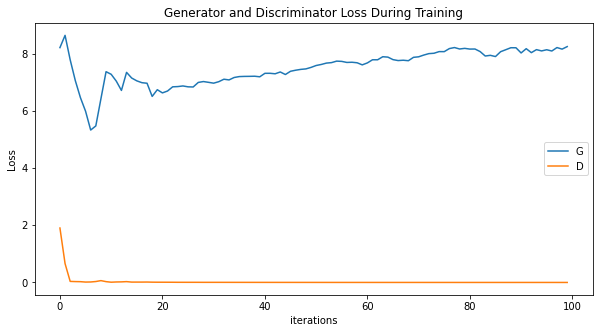

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

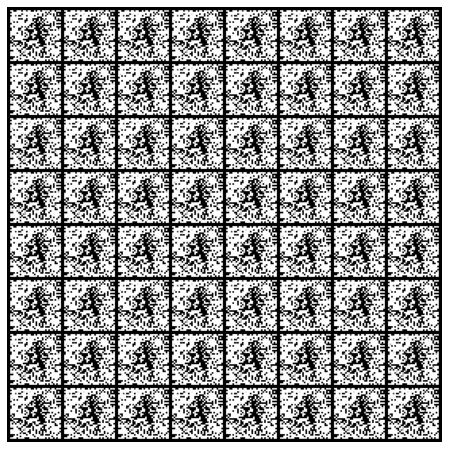

In [15]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.cpu(),(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

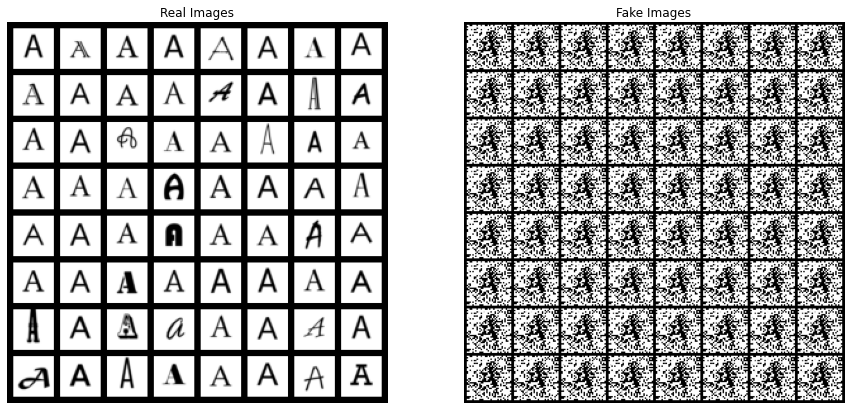

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(data_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))
plt.show()

In [21]:
torch.save(generator.state_dict(), "models/Generator_cGANMix_Fonts")
torch.save(discriminator.state_dict(), "models//Discriminator_cGANMix_Fonts")

In [22]:
generator = GeneratorModel()
generator.load_state_dict(torch.load("models/Generator_cGANMix_Fonts"))

discriminator = DiscriminatorModel()
discriminator.load_state_dict(torch.load("models/Discriminator_cGANMix_Fonts"))

<All keys matched successfully>